In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

df = pd.read_csv('train.csv')
pd.set_option('display.max_columns', None)

In [2]:
df.drop(df.columns[[0, 1, 2]], axis=1, inplace=True)
df.head()

,PTS,STARTED,WMA_PTS_3,WMA_FG2A_3,WMA_FG3A_3,WMA_MIN_3,WMA_FG_PCT_3,WMA_FG3_PCT_3,WMA_FT_PCT_3,WMA_UR_3,WMA_PTS_5,WMA_FG2A_5,WMA_FG3A_5,WMA_MIN_5,WMA_FG_PCT_5,WMA_FG3_PCT_5,WMA_FT_PCT_5,WMA_UR_5,AVG_PTS_10,AVG_FG2A_10,AVG_FG3A_10,AVG_MIN_10,AVG_FG_PCT_10,AVG_FG3_PCT_10,AVG_FT_PCT_10,AVG_UR_10,AVG_OREB_10,STD_PTS_10,STD_MIN_10,STD_FG_PCT_10,STD_FG3_PCT_10,STD_UR_10,HOME_AWAY_RATIO,HOME_AWAY_MEANINGFUL,HOME,RATIO_2_to_3,VOLATILITY_RATIO_PTS,UNPREDICTABLE,HEATING_OR_COOLING,CHANGE_OF_ROLE
0,8,0.0,6.000000,2.833333,4.500000,18.908333,0.392167,0.361333,0.000000,16.377268,5.400000,2.666667,1.800000,22.012222,0.512533,0.144533,0.366667,9.494121,8.3,3.3,3.3,23.300000,0.5128,0.3518,0.3250,12.748741,0.2,5.273519,7.109438,0.183980,0.294618,6.008630,-0.336295,1,1,1.000000,0.635364,1,-2.300000,-4.391667
1,13,1.0,19.833333,6.000000,9.000000,29.451389,0.455833,0.319500,0.958333,21.160920,18.666667,6.066667,6.800000,28.935000,0.527667,0.363400,0.805667,19.034503,16.9,5.3,6.0,27.580500,0.5756,0.4363,0.6967,16.990519,0.1,3.986226,3.373667,0.168975,0.246020,4.347180,-0.051493,0,1,0.883333,0.235871,0,2.933333,1.870889
2,20,1.0,19.333333,9.333333,4.333333,36.493889,0.564333,0.277833,0.958333,16.982360,19.933333,8.000000,5.666667,36.750889,0.470200,0.298667,0.983333,16.148166,18.0,8.4,6.5,36.878667,0.4282,0.3216,0.9750,18.112560,1.0,4.919350,4.062636,0.138119,0.165450,4.296579,0.146929,0,0,1.292308,0.273297,0,1.333333,-0.384778
3,6,0.0,2.000000,1.166667,0.000000,5.805556,0.833333,0.000000,0.333333,11.054036,0.800000,0.466667,0.000000,3.488667,0.333333,0.000000,0.133333,4.421614,1.2,0.8,0.3,4.656167,0.2833,0.0000,0.2500,9.148563,0.2,1.077033,2.744594,0.394753,0.000000,9.024665,-0.340909,1,0,2.666667,0.897527,1,0.800000,1.149389
4,7,1.0,11.000000,5.333333,1.500000,19.726111,0.783333,0.750000,0.000000,15.318250,4.400000,2.133333,0.600000,8.595444,0.313333,0.300000,0.000000,6.493302,2.9,1.4,0.5,6.958833,0.2833,0.2500,0.0000,7.168512,0.4,4.846648,8.297051,0.379249,0.403113,9.359277,1.000000,1,1,2.800000,1.671258,1,8.100000,12.767278


In [13]:

X = df.drop(columns=['PTS'], axis=1)
y = df['PTS']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', verbosity=0)

param_grid = {
    'n_estimators': [350, 400],
    'max_depth': [4],
    'learning_rate': [0.05],
    'subsample': [0.8, 0.85]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 350, 'subsample': 0.8}


In [15]:
# Convert to DMatrix for logging eval
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

final_model = xgb.train(
    params={
        'objective': 'reg:squarederror',
        'max_depth': grid.best_params_['max_depth'],
        'learning_rate': grid.best_params_['learning_rate'],
        'subsample': grid.best_params_['subsample']
    },
    dtrain=dtrain,
    num_boost_round=grid.best_params_['n_estimators'],
    evals=[(dval, 'validation')],
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	validation-rmse:8.38149
[1]	validation-rmse:8.17542
[2]	validation-rmse:7.98470
[3]	validation-rmse:7.80837
[4]	validation-rmse:7.64593
[5]	validation-rmse:7.49534
[6]	validation-rmse:7.35682
[7]	validation-rmse:7.22956
[8]	validation-rmse:7.11219
[9]	validation-rmse:7.00465
[10]	validation-rmse:6.90633
[11]	validation-rmse:6.81604
[12]	validation-rmse:6.73314
[13]	validation-rmse:6.65772
[14]	validation-rmse:6.58876
[15]	validation-rmse:6.52567
[16]	validation-rmse:6.46760
[17]	validation-rmse:6.41461
[18]	validation-rmse:6.36688
[19]	validation-rmse:6.32286
[20]	validation-rmse:6.28147
[21]	validation-rmse:6.24484
[22]	validation-rmse:6.21125
[23]	validation-rmse:6.18048
[24]	validation-rmse:6.15232
[25]	validation-rmse:6.12632
[26]	validation-rmse:6.10262
[27]	validation-rmse:6.08098
[28]	validation-rmse:6.06161
[29]	validation-rmse:6.04377
[30]	validation-rmse:6.02788
[31]	validation-rmse:6.01275
[32]	validation-rmse:5.99828
[33]	validation-rmse:5.98602
[34]	validation-rmse:5.9

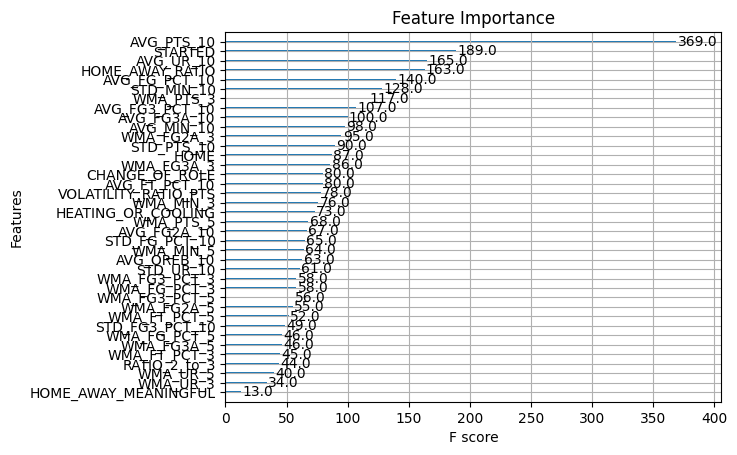

In [16]:
# Using built-in plot
xgb.plot_importance(final_model)
plt.title("Feature Importance")
plt.show()

In [58]:
df.drop(columns=['HOME', 'MIN_LAST_3_DAYS', 'PLAYER_TEAM_OFF_RATING', 
                'OPP_WINS_LAST_10', 'AST_SEASON_AVG', 'AWAY_GAMES_IN_A_ROW',
                'FG3A_SEASON_AVG', 'OPP_DEF_RATING', 'BLK_SEASON_AVG',
                'WMA_FT_PCT_LAST_3', 'WMA_FTA_LAST_3', 'STL_SEASON_AVG'], 
                axis=1, inplace=True)

In [37]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.linear_model import Ridge


tabnet = TabNetRegressor(verbose=1)
tabnet.fit(
    X_train=X_train.values, y_train=y_train.values.reshape(-1, 1),
    eval_set=[(X_val.values, y_val.values.reshape(-1, 1))],
    eval_metric=['rmse'],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 49.43093| val_0_rmse: 6.5838  |  0:00:04s
epoch 1  | loss: 35.47753| val_0_rmse: 5.94363 |  0:00:07s
epoch 2  | loss: 35.36566| val_0_rmse: 5.9161  |  0:00:10s
epoch 3  | loss: 35.17817| val_0_rmse: 5.94461 |  0:00:14s
epoch 4  | loss: 35.25494| val_0_rmse: 5.91432 |  0:00:17s
epoch 5  | loss: 34.89214| val_0_rmse: 5.86536 |  0:00:21s
epoch 6  | loss: 34.74041| val_0_rmse: 5.88347 |  0:00:24s
epoch 7  | loss: 34.64373| val_0_rmse: 5.86096 |  0:00:28s
epoch 8  | loss: 34.638  | val_0_rmse: 5.85944 |  0:00:32s
epoch 9  | loss: 34.49733| val_0_rmse: 5.86186 |  0:00:35s
epoch 10 | loss: 34.58579| val_0_rmse: 5.88524 |  0:00:39s
epoch 11 | loss: 34.42245| val_0_rmse: 5.84447 |  0:00:42s
epoch 12 | loss: 34.46007| val_0_rmse: 5.90547 |  0:00:46s
epoch 13 | loss: 34.27483| val_0_rmse: 5.85708 |  0:00:49s
epoch 14 | loss: 34.32225| val_0_rmse: 5.87605 |  0:00:53s
epoch 15 | loss: 34.25726| val_0_rmse: 5.85891 |  0:00:56s
epoch 16 | loss: 34.27568| val_0_rmse: 5.84012 |  0:01:0